### Timeseries classification

In this notebook a binaray classification model is created to predict if corals at a given location is bleached(1) or not(0) based on timeseries with daily sea surface temperatures for that given location. 

The training data is daily sea surface temperatures from 2009-2019 from NOAA for the eco regions:
Bahamas and Florida Keys                         
Belize and west Caribbean                     
Hispaniola, Puerto Rico and Lesser Antilles

The labels of the training data is created based on data from the field "Bleaching Percentage" of the Bleaching DB. 
If Bleaching Percentage > 60 the label == 1 else 0. 

A label is from the latest sample of that location
The coordinates are the coordinates found in the sea sureface temperature dataset, 
and is not always an exact match to the cordinates found in Bleaching DB (the values were rounded to 1 decimal to find matches in both datasets). 

The notebook is created based on this guide, where you can find more details about each step:
https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

In [ ]:
import sys

!{sys.executable} -m pip install tensorflow
from tensorflow import keras
from tensorflow import math
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
from sklearn.preprocessing import StandardScaler
from math import sqrt
import json

!{sys.executable} -m pip install seaborn
import seaborn as sns

2022-04-27 18:37:51.999984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 18:37:52.000034: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load training data and labels

In [ ]:
# Open JSON file with labels.
file = open(
    "/home/jovyan/Ocean Data Platform Tutorials/data/NOAA Coral Reef Watch/label_dict.json",
)
target_dict = json.load(file)
file.close()

In [ ]:
# Open CSV file with timeseries data (one column for each location, one row for each datapoint (day))
training_data_file_path = "test_data2/seasurface_temp_training_data.csv"
training_data = pd.read_csv(training_data_file_path)

In [ ]:
training_data.shape

(7306, 1307)

### Standardize timeseries data

Rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1 by using sklearn StandardScaler. 

In [ ]:
# read all columns to get temperature values from all timeseries
all_temperature_list = []
locations = training_data.columns
for location in locations[2:]:
    all_temperature_list.extend(training_data[location].tolist())

Plot Distribution of all temerature timeseries

<Figure size 576x576 with 0 Axes>

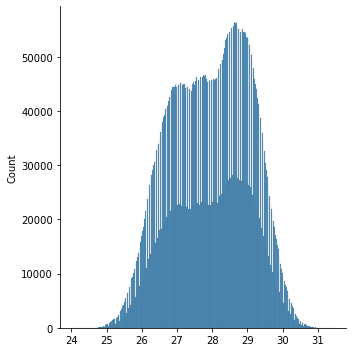

In [ ]:
plt.figure(figsize=(8, 8))
sns.displot(all_temperature_list)

In [ ]:
values = np.array(all_temperature_list)
values = values.reshape((len(values), 1))
# Train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)
print("Mean: %f, StandardDeviation: %f" % (scaler.mean_, sqrt(scaler.var_)))

Mean: 27.950613, StandardDeviation: 1.111375


In [ ]:
sequences = list()
targets = list()
sequences2 = list()
targets2 = list()

start_row = 3000  # the csv contains data from 2000, reduce datapoints by not including early years in training data
end_row = (
    7000  # remove last year of data (2020) as bleaching samples are from 2019 or before
)

for location in locations[2:]:
    if location in target_dict:
        values = np.array(training_data[location].fillna(0).iloc[start_row:end_row])
        values = values.reshape((len(values), 1))
        # seperate in 2 lists to create a balanced training set
        if target_dict[location] == 0:
            sequences2.append(np.array(scaler.transform(values)))
            targets2.append(target_dict[location])
        else:
            targets.append(target_dict[location])
            sequences.append(np.array(scaler.transform(values)))

### Split dataset to train and test

In [ ]:
train_len = round(len(targets) * 0.9)
test_len = len(targets) - train_len

In [ ]:
train = [sequences[i] for i in range(0, train_len)] + [
    sequences2[i] for i in range(0, train_len)
]  # equal amount of 1s and 0s to balance the training set
test = [sequences[i] for i in range(train_len, train_len + test_len)] + [
    sequences2[i] for i in range(train_len, train_len + test_len + 10)
]

train_target = [targets[i] for i in range(0, train_len)] + [
    targets2[i] for i in range(0, train_len)
]
test_target = [targets[i] for i in range(train_len, train_len + test_len)] + [
    targets2[i] for i in range(train_len, train_len + test_len + 10)
]

In [ ]:
x_train = np.array(train).astype("float32")
x_test = np.array(test).astype("float32")
y_train = np.array(train_target)
y_test = np.array(test_target)

In [ ]:
x_train.shape

(398, 4000, 1)

### Visualize 1 timeseries example for each class (bleaching vs no bleaching).

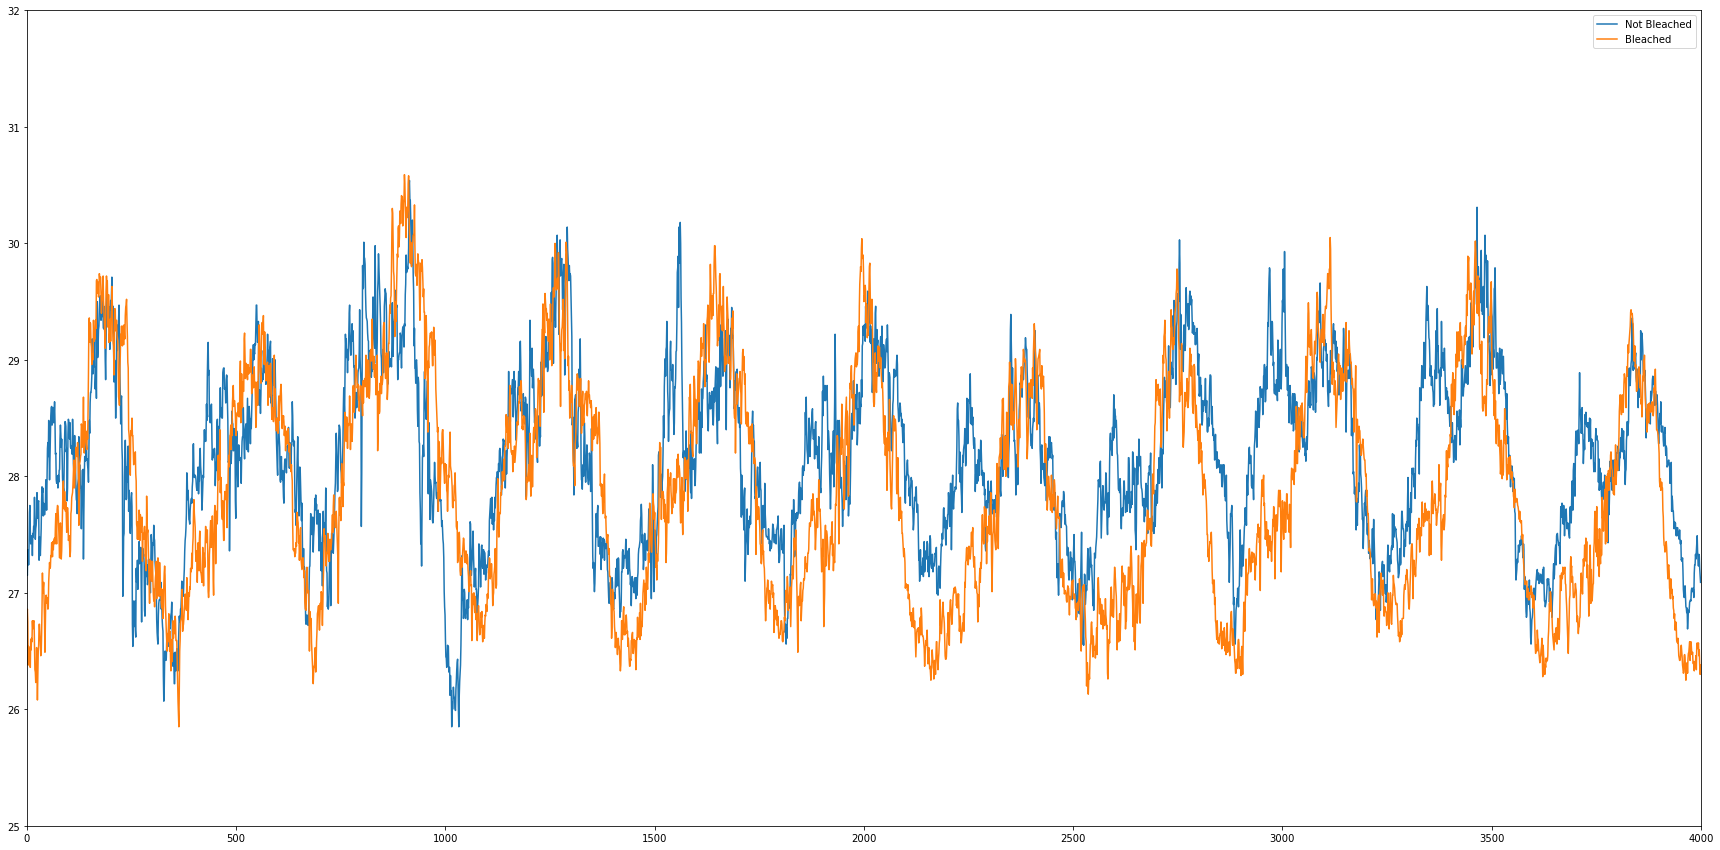

In [ ]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))
plt.figure(figsize=(30, 15))
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(
        scaler.inverse_transform(c_x_train[0]),
        label="Bleached" if c == 1 else "Not Bleached",
    )

plt.legend(loc="best")
ax = plt.gca()
ax.axis([0, (end_row - start_row), 25, 32])
plt.show()
plt.close()

### Make model

In [ ]:
num_classes = len(np.unique(y_train))

In [ ]:
# Shuffle training set the last X % of the training set will be used as validation on model (X is defined in validation_split option).
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=10, padding="same")(
        input_layer
    )
    conv1 = keras.layers.ReLU()(conv1)
    conv1 = keras.layers.BatchNormalization(axis=1)(conv1)

    conv2 = keras.layers.Conv1D(filters=128, kernel_size=10, padding="same")(conv1)
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.BatchNormalization(axis=1)(conv2)

    conv3 = keras.layers.Conv1D(filters=128, kernel_size=10, padding="same")(conv2)
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.BatchNormalization(axis=1)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


2022-04-27 18:38:06.326677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-27 18:38:06.326766: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-27 18:38:06.326798: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-marie-2elepoutre-40cognite-2ecom): /proc/driver/nvidia/version does not exist
2022-04-27 18:38:06.327059: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train model

In [ ]:
epochs = 200
batch_size = 5
adam = Adam(lr=0.005)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ts_classification_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.05, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer=adam,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/200
64/64 [==============================] - 27s 429ms/step - loss: 0.6716 - sparse_categorical_accuracy: 0.6038 - val_loss: 0.7262 - val_sparse_categorical_accuracy: 0.4875 - lr: 0.0050
Epoch 4/200
64/64 [==============================] - 27s 427ms/step - loss: 0.6801 - sparse_categorical_accuracy: 0.6195 - val_loss: 0.7037 - val_sparse_categorical_accuracy: 0.6250 - lr: 0.0050
Epoch 5/200
64/64 [==============================] - 27s 421ms/step - loss: 0.6971 - sparse_categorical_accuracy: 0.6038 - val_loss: 0.7476 - val_sparse_categorical_accuracy: 0.4750 - lr: 0.0050
Epoch 6/200
64/64 [==============================] - 27s 418ms/step - loss: 0.6884 - sparse_categorical_accuracy: 0.5975 - val_loss: 0.7481 - val_sparse_categorical_accuracy: 0.5625 - lr: 0.0050
Epoch 7/200
64/64 [==============================] - 27s 419ms/step - loss: 0.6526 - sparse_categorical_accuracy: 0.6384 - val_loss: 0.9169 - val_sparse_categorical_accuracy: 0.5500 - lr: 0.0050
Epoch 8/200
64/64 [======

In [ ]:
model.save("ts_classification_model.h5")

### Plot the model's training and validation accuracy

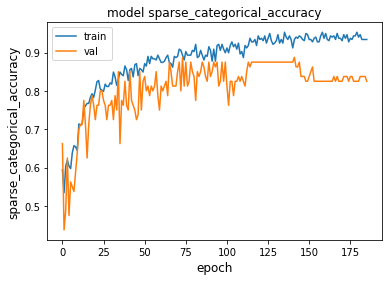

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

### Evaluate model on test data

In [ ]:
model = keras.models.load_model("ts_classification_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 [==============================] - 1s 307ms/step - loss: 0.3939 - sparse_categorical_accuracy: 0.8704
Test accuracy 0.8703703880310059
Test loss 0.3939410448074341


### Plot confusion matrix

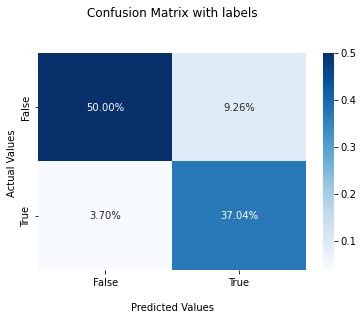

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
cf_matrix = math.confusion_matrix(y_test, y_pred)

# count
# ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

#%
ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt=".2%", cmap="Blues")

ax.set_title("Confusion Matrix with labels\n\n")
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values ")

ax.xaxis.set_ticklabels(["False", "True"])
ax.yaxis.set_ticklabels(["False", "True"])
plt.show()

### Suggestions for further tuning and improvements of the model

Tune the model by changing parameters such as:
* filters
* kernel_size
* batch size
* learning rate (lr)
* Epochs

Other suggestions of improvements:
* Increase the number of datapoints by using the entire dataset as in the csv
* Could we introduce more classes(labels) by using the "Bleaching_Label" in the bleaching_data.csv file? This would categorize the timeseries into 3 classes. 
* Could aggregated sea surface temperature timeseries data be used? Such as weekly/monthly average temperature, weekly/monthly min/max temperature? 
* Could other timeseries data be used ? Such as tidewaves, pH, nitrate-,  phosphate- and silicate content, alkalinity, salinity